In [532]:
import pandas as pd

In [539]:
data = '20231109_D&I_Platform Bugs'

In [540]:
df = pd.read_csv(data+'.csv')
df = df.drop(['remarks', 'is_major', 'is_solved'], axis=1)

df['created_at'] = pd.to_datetime(df['created_at'])
df['solved_at'] = pd.to_datetime(df['solved_at'])
df['date'] = df['created_at'].dt.date
df = df[['date', 'bug_class', 'solved_at']]

In [548]:
# fill data
start_date = '2023-04-18'
end_date = '2023-11-09'
# Create a complete date range using the range method
complete_date_range = pd.DataFrame(index=pd.date_range(start=start_date, end=end_date, freq='D'))

### Bug

In [549]:
df['bug_count'] = 1
bug_counts = df.groupby(['date', 'bug_class']).count()['bug_count'].reset_index()
bug_pivot = bug_counts.pivot_table(index='date', columns='bug_class', values='bug_count', fill_value=0)
# Merge the existing DataFrame with the complete DataFrame, filling missing values with zeros
result_df_bug = complete_date_range.merge(bug_pivot, how='left', left_index=True, right_index=True).fillna(0)

### Solved

In [550]:
#solved
solved_counts = df.groupby(['solved_at', 'bug_class']).size().unstack(fill_value=0).reset_index()
solved_counts['date'] = solved_counts['solved_at'].dt.date 
solved_counts = solved_counts.set_index('date')
solved_counts = solved_counts[['Major', 'Minor']]

# Merge the existing DataFrame with the complete DataFrame, filling missing values with zeros
result_df_solved = complete_date_range.merge(solved_counts, how='left', left_index=True, right_index=True).fillna(0)

### Processed

In [551]:
# Get cu
final = result_df_bug - result_df_solved
final['cumulative_major'] = final['Major'].cumsum()
final['cumulative_minor'] = final['Minor'].cumsum()

<Axes: >

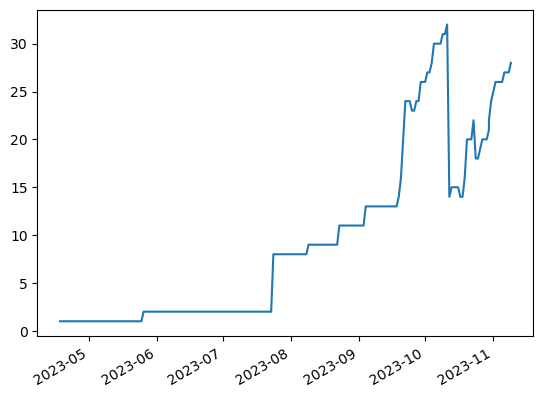

In [552]:
final['cumulative_major'].plot()

In [553]:
df_final = final[['cumulative_major', 'cumulative_minor']]

In [555]:
df_final.to_csv('bug.csv')

# Inquiry

In [561]:
# fill data
start_date = '2023-03-01'
end_date = '2023-11-09'
# Create a complete date range using the range method
complete_date_range = pd.DataFrame(index=pd.date_range(start=start_date, end=end_date, freq='D'))

In [562]:
df_inq = pd.read_csv('20231106_D&I_CR Inquiry.csv')
df_inq = df_inq[['status', 'created_at', 'resolved_at', 'tag']]
df_inq['tag'] = df_inq['tag'].astype(str)

In [563]:
df_inq['status'].value_counts()

resolved      1296
unassigned     169
assigned       120
Name: status, dtype: int64

In [564]:
df_inq_filtered = df_inq[~df_inq['tag'].str.contains('spam')]

In [565]:
df_inq_filtered['created_at'] = pd.to_datetime(df_inq_filtered['created_at']).dt.date
df_inq_filtered['resolved_at'] = pd.to_datetime(df_inq_filtered['resolved_at']).dt.date

/var/folders/fh/5kqpbzgx5cgdq_m9npj98tfh0000gn/T/ipykernel_48710/725214265.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inq_filtered['created_at'] = pd.to_datetime(df_inq_filtered['created_at']).dt.date
/var/folders/fh/5kqpbzgx5cgdq_m9npj98tfh0000gn/T/ipykernel_48710/725214265.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inq_filtered['resolved_at'] = pd.to_datetime(df_inq_filtered['resolved_at']).dt.date


In [566]:
inq = df_inq_filtered['created_at'].value_counts().reset_index()
inq.rename(columns={'index':'date', 'created_at':'count'}, inplace=True)
inq.sort_values('date', inplace=True)
inq.set_index('date', inplace=True)

In [567]:
df_inq_res = complete_date_range.merge(inq, how='left', left_index=True, right_index=True).fillna(0)

In [568]:
df_inq_reso = df_inq_filtered.groupby(['resolved_at', 'status']).size().unstack(fill_value=0).reset_index()
df_inq_reso = df_inq_reso.rename(columns={'resolved_at':'date', 'resolved':'count'})
df_inq_reso['date'] = pd.to_datetime(df_inq_reso['date'])
df_inq_reso.set_index('date', inplace=True)

In [569]:
df_reso_merged = complete_date_range.merge(df_inq_reso, how='left', left_index=True, right_index=True).fillna(0)
df_reso_merged

,count
2023-03-01,0.0
2023-03-02,1.0
2023-03-03,0.0
2023-03-04,1.0
2023-03-05,0.0
...,...
2023-11-05,0.0
2023-11-06,6.0
2023-11-07,5.0
2023-11-08,1.0


In [570]:
result = df_inq_res - df_reso_merged
result['cum'] = result['count'].cumsum()

<Axes: >

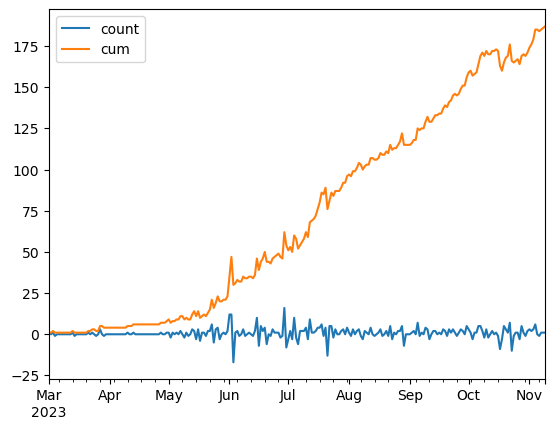

In [571]:
result.plot()

In [572]:
result[['cum']].to_csv('inq.csv')